In [1]:
import sys
sys.path.insert(0, '../Tilings') # prepend the path to the Tiling package

import CP as CP
import Tilings as tl
import QuantumGraph as QGraph

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

import networkx as nx

import scipy.linalg
from scipy.sparse.linalg import eigsh

import itertools

# interactivity in the notebook
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

# replace by %matplotlib notebook for full interactivity (but beware of the flickering!)
%matplotlib notebook

# Details of the phason flip algorithm
This section presents in details the algorithm we use to perform -- manually -- phason flips on an approximant.
The input of the algorithm is a tiling (in form of a graph whose nodes are integers) and the axis along which we want to perform the flip.
The algorithm is as follows:
* Find the labels of the nodes which are going to flip
* Find the new positions of these nodes
* Find their neighbors
* Update the graph

<IPython.core.display.Javascript object>


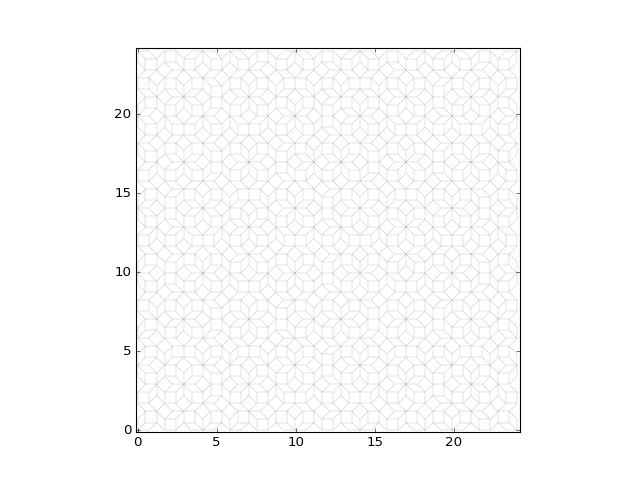

In [2]:
def square0(orig, ea, eb):
    """
    create a square with edges along ea and eb
    the arrows of the square are directed by ea and eb
    """
    if not np.isclose(np.vdot(ea, eb).real, 0, atol = 1e-10):
        raise RuntimeError("The specified edges cannot be used to create a square " + str(np.vdot(ea, eb).real))
    
    B = orig
    A = orig + ea
    C = orig + ea + eb
    t1 = (1, (A, B, C))
    
    A = orig + eb
    t2 = (1, (A, B, C))
    
    return [t1, t2]

n = 4 # number of inflations

# create a tiling whose basic tile is a square
e = np.identity(4)
square = tl.A5(square0(np.zeros(4),e[0],e[2]))
square.it_sub(n)

L = 24.1
delt = 0.1
plt.close()
QGraph.plot(square._graph, lims=((-delt,L+delt),(-delt,L+delt)))
plt.show()

In [45]:
"""
Input parameters
"""

# the label of the axis we want to jump (labeled from 0 to 7, 0 is the leftmost window edge and we run counterclockwise)
ax = 2
# label the nodes by integers
g = nx.convert_node_labels_to_integers(square._graph, label_attribute = 'pos')

<IPython.core.display.Javascript object>


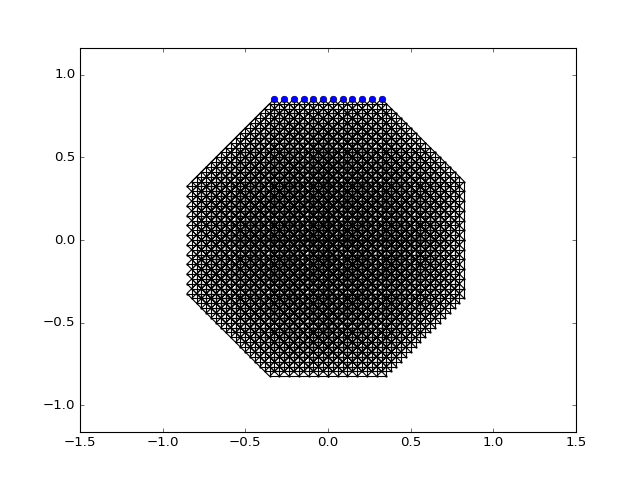

In [41]:
"""
Find labels of the nodes we jump
"""

pi = np.pi

def r(theta):
    """
    Return 2D rotation matrix of angle theta
    """
    return np.array([[np.cos(theta), -np.sin(theta)], 
                         [np.sin(theta),  np.cos(theta)]])

def edge_nodes(g, n):
    """
    Return the extreme points of g lying in direction 2*n*pi/8 (wrt to horizontal) and in the orthogonal direction
    """
    # get the positions of the nodes
    pos = np.asarray(list(nx.get_node_attributes(g, 'perp').values()))
    # angle by which to rotate to bring wanted axis to the horizontal direction
    theta = -2.*n*pi/8.
    # rotate
    rot_mat = r(theta)
    pos = np.dot(rot_mat, pos.T).T
    # find the extreme points
    x, y = zip(*pos)
    xmax = max(x) # rightmost abscissa
    xmin = min(x)
    ymin = min(y)
    ymax = max(y)
    
    # tolerance is one percent of the average distance between two nodes
    av_dist = min(xmax-xmin, ymax-ymin)/np.sqrt(len(x))    
    tol = 0.01*av_dist

    right_nodes = []

    for p in g.nodes(data=True):
        px, py = np.dot(rot_mat, p[1]['perp'])
        if np.isclose(px, xmax, atol=tol):
             right_nodes.append(p[0])

    return right_nodes

# edge nodes along wanted axis
eds = edge_nodes(g, ax)

# plot everything
plt.close()
perppts = np.array([g.node[n]['perp'] for n in eds])
nx.draw_networkx(g, nx.get_node_attributes(g, 'perp'), with_labels = False, node_size= 1., width = 1)
plt.axes().set_aspect('equal', 'datalim')
plt.plot(*(perppts.T), 'o')

In [37]:
"""
Find new positions and new neighbors
"""

# return the 3 edges connecting to the opposite edge
neighs = {0:(e[1],-e[0],-e[3]),1:(-e[0],-e[3],e[2]),2:(-e[3],e[2],-e[1]),
          3:(e[2],-e[1],e[0]),4:(-e[1],e[0],e[3]),5:(e[0],e[3],-e[2]),6:(e[3],-e[2],e[1]),7:(-e[2],e[1],-e[0])}
# return the 4D position given the label
position = nx.get_node_attributes(g, 'pos')
# return the label given the position
lbl = dict((v,k) for k,v in position.items())

ns = neighs[ax]
# translation vector from one edge to the opposing one
a = sum(ns)
# positions of the jumped nodes
new_pos = [position[edge_node] + a for edge_node in eds]
# positions of the neighbors of the jumped nodes
new_neighs = [[(en, lbl[tuple(np - v)]) for v in ns if tuple(np - v) in lbl.keys()] for en, np in zip(eds, new_pos)]

In [38]:
"""
Recompute node attributes
"""

g1 = g.copy()

# projection matrices
P = square.para()
Pi = square.perp_proj()

for label, pos, neighs in zip(eds, new_pos, new_neighs):
    # change the position label
    g1.node[label]['pos'] = pos
    # recompute the projections and change them
    g1.node[label]['para'] = np.dot(P, pos)
    g1.node[label]['perp'] = np.dot(Pi, pos)
    # remove the old neighbors
    old_edges = map(lambda n: (label,n), g1.neighbors(label))
    g1.remove_edges_from(old_edges)
    # add the new neighbors
    g1.add_edges_from(neighs)

<IPython.core.display.Javascript object>


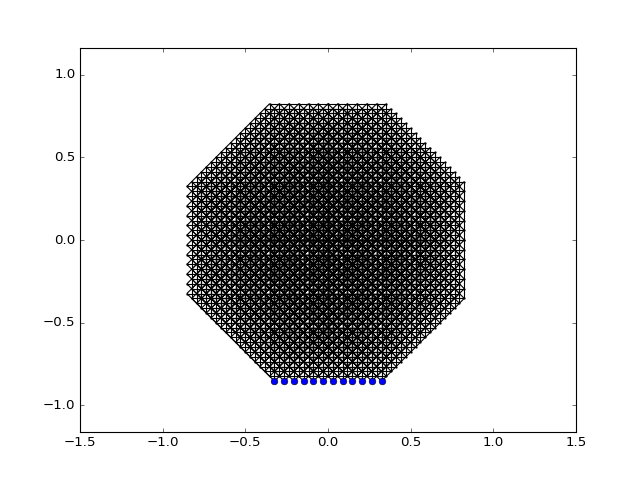

In [39]:
# plot everything
plt.close()
perppts = np.array([np.dot(Pi, n) for n in new_pos])
nx.draw_networkx(g1, nx.get_node_attributes(g1, 'perp'), with_labels = False, node_size= 1., width = 1)
plt.axes().set_aspect('equal', 'datalim')
plt.plot(*(perppts.T), 'o')

<IPython.core.display.Javascript object>


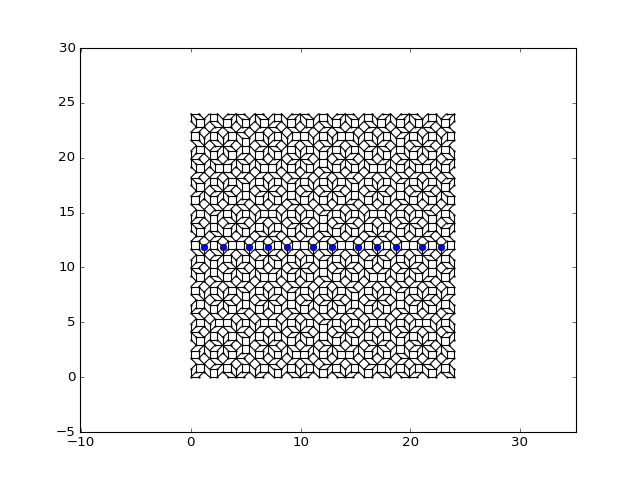

In [40]:
# plot everything
plt.close()
parapts = np.array([g1.node[n]['para'] for n in eds])
nx.draw_networkx(g1, nx.get_node_attributes(g1, 'para'), with_labels = False, node_size= 1., width = 1)
plt.axes().set_aspect('equal', 'datalim')
plt.plot(*(parapts.T), 'o')

# Putting everything together
Now we assemble the elements into a function that takes as its imput a graph and a jump direction, and returns the updated graph

In [10]:
def o(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + 2*b
    return a

def lattice(n):
    """
    Lattice vectors of the nth approximant
    """
    a = o(n)
    b = o(n-1)
    return np.array([[a+b,a,0,-a],[0,a,a+b,a]])

def para_mat(n):
    """
    Projection matrix onto physical space
    """
    r = o(n-1)/o(n)
    sgn = (-1)**n
    para = np.array([[1.+r,1.,0,-1.],[0,1.,1.+r,1.]])
    normpara = np.sqrt(4.+sgn/o(n)**2)
    para /= normpara
    return para

def in_unit_cell(n, p):
    """
    Modify the positions p so that it falls in the canonical unit cell of the nth approximant
    """
    # lattice vectors
    A, B = lattice(n)
    # linear length of the unit cell
    L = np.sqrt(np.dot(A,A)) + 0.1
    # projection onto physical space
    pp = np.dot(para_mat(n), p)
    # number of translations needed in both directions
    nx, ny = np.floor(pp/L)
    return p - nx*A - ny*B

In [4]:
def r(theta):
    """
    Return 2D rotation matrix of angle theta
    """
    return np.array([[np.cos(theta), -np.sin(theta)], 
                         [np.sin(theta),  np.cos(theta)]])

def edge_nodes(g, n):
    """
    Return the extreme points of g lying in direction 2*n*pi/8 (wrt to horizontal) and in the orthogonal direction
    """
    # get the positions of the nodes
    pos = np.asarray(list(nx.get_node_attributes(g, 'perp').values()))
    # angle by which to rotate to bring wanted axis to the horizontal direction
    theta = -2.*n*np.pi/8.
    # rotate
    rot_mat = r(theta)
    pos = np.dot(rot_mat, pos.T).T
    # find the extreme points
    x, y = zip(*pos)
    xmax = max(x) # rightmost abscissa
    xmin = min(x)
    ymin = min(y)
    ymax = max(y)
    
    # tolerance is one percent of the average distance between two nodes
    av_dist = min(xmax-xmin, ymax-ymin)/np.sqrt(len(x))    
    tol = 0.01*av_dist

    right_nodes = []

    for p in g.nodes(data=True):
        px, py = np.dot(rot_mat, p[1]['perp'])
        if np.isclose(px, xmax, atol=tol):
             right_nodes.append(p[0])

    return right_nodes

def phason_flip(ninf, graph, axis):
    """
    Update graph to make points along axis jump.
    axis is an integer from 0 to 7, where 0 is the leftmost window edge and we run counterclockwise.
    ninf is the order of the approximant (needed to ensure points stay within the unit cell).
    """
    # return the 4D vectors linking a jumped site to its new neighbors
    neighs = {0:(e[1],-e[0],-e[3]),1:(-e[0],-e[3],e[2]),2:(-e[3],e[2],-e[1]),
              3:(e[2],-e[1],e[0]),4:(-e[1],e[0],e[3]),5:(e[0],e[3],-e[2]),6:(e[3],-e[2],e[1]),7:(-e[2],e[1],-e[0])}

    # projection matrices
    P = square.para()
    Pi = square.perp_proj()

    # edge nodes along wanted axis
    eds = edge_nodes(graph, axis)

    # return the 4D position given the label
    position = nx.get_node_attributes(graph, 'pos')
    # return the label given the position
    lbl = dict((tuple(v),k) for k,v in position.items())

    # 4D vectors linking a jumped site to its new neighbors
    ns = neighs[axis]
    # translation vector from one edge to the opposing one
    a = sum(ns)
    # positions of the jumped nodes
    new_pos = [position[edge_node] + a for edge_node in eds]
    # correct the positions so that they fall in the unit cell
    new_pos = list(map(lambda p: in_unit_cell(ninf, p), new_pos))
    # positions of the neighbors of the jumped nodes
    new_neighs = [[(en, lbl[tuple(np - v)]) for v in ns if tuple(np - v) in lbl.keys()] for en, np in zip(eds, new_pos)]

    # update the graph
    for label, pos, neighs in zip(eds, new_pos, new_neighs):
        # change the position label
        graph.node[label]['pos'] = pos
        # recompute the projections and change them
        graph.node[label]['para'] = np.dot(P, pos)
        graph.node[label]['perp'] = np.dot(Pi, pos)
        # remove the old neighbors
        old_edges = map(lambda n: (label,n), graph.neighbors(label))
        graph.remove_edges_from(old_edges)
        # add the new neighbors
        graph.add_edges_from(neighs)
    
    # return the points that have been fliped
    return eds

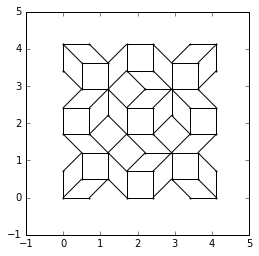

In [88]:
n = 2
square = tl.A5(square0(np.zeros(4),e[0],e[2]))
square.it_sub(n)
g = square._graph

pps = g.nodes()
pps = np.array(list(map(lambda p: in_unit_cell(n, p), pps)))

parapos = np.dot(square.para(), pps.T).T
dictpos = dict((node, pos) for node, pos in zip(g.nodes(), parapos))

plt.close()
nx.draw_networkx(g, dictpos, with_labels = False, node_size= 1., width = 1)
plt.axes().set_aspect('equal')

In [7]:
n = 2 # number of inflations

# create a tiling whose basic tile is a square
e = np.identity(4)
square = tl.A5(square0(np.zeros(4),e[0],e[2]))
square.it_sub(n)

def flip_and_plot(n, graph, axis):
    g = graph.copy()
    eds = phason_flip(n, g, axis)
    
    plt.close()
    # plot in perp and para spaces
    fig, ax = plt.subplots(1, 2)
    # node size
    node_size = 20.*(np.sqrt(2)-1.)**(2*n)
    # marker size (used in plot)
    markersize = 2.
    
    perp_pos = nx.get_node_attributes(g, 'perp')
    ax[0].set_aspect('equal')
    nx.draw_networkx(g, perp_pos, with_labels = False, node_size = node_size, width = 0., ax = ax[0])
    perppts = np.array([g.node[n]['perp'] for n in eds])
    ax[0].plot(*(perppts.T), 'o', markersize = markersize)
    
    para_pos = nx.get_node_attributes(g, 'para')
    ax[1].set_aspect('equal')
    nx.draw_networkx(g, para_pos, with_labels = False, node_size = node_size, width = .5, ax = ax[1])
    parapts = np.array([g.node[n]['para'] for n in eds])
    ax[1].plot(*(parapts.T), 'o', markersize = markersize)

    return g

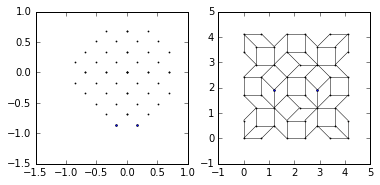

In [182]:
# label the nodes by integers
g = nx.convert_node_labels_to_integers(square._graph, label_attribute = 'pos')
g = flip_and_plot(n, g, 2)

In [5]:
def plot2(n, graph, axis, savename):
    graph = flip_and_plot(n, graph, axis)
    plt.savefig(str(savename) + ".png", dpi=200)
    return graph

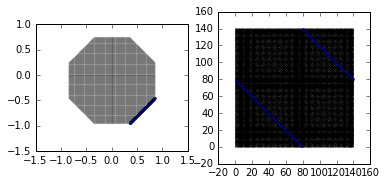

In [12]:
%matplotlib inline

n = 6
square = tl.A5(square0(np.zeros(4),e[0],e[2]))
square.it_sub(n)
g = nx.convert_node_labels_to_integers(square._graph, label_attribute = 'pos')

count = 0
for i in range(20):
    if i%2 == 0:
        g = plot2(n, g, 2, count)
        count += 1
    else:
        g = plot2(n, g, 1, count)
        count += 1
        g = plot2(n, g, 2, count)
        count += 1
        g = plot2(n, g, 3, count)
        count += 1

## Periodized cells
The algorithm as it is does not work if the cell is periodized (ie wrapped on a torus).
Indeed, it does not check for neighbors of a jumped sites "up to a period".
A way around is to perform the jump first, and then to periodize the system.

Below we check that the number of bonds stays the same after periodizing as described.
We can also check that it has the correct value of two times the number of sites (the average coordination is 4).
Sadly, it doesn't always work!!

2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2786
2774
2775
2775
2776
2776
2777
2777
2778
2778
2779
2779
2780
2780
2781
2781
2782
2782
2783
2783
2784
2784
2785
2785
2786
2786
2787
2787
2788
2788
2789
2789
2790
2790
2791
2779
2778


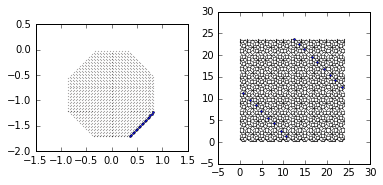

In [18]:
%matplotlib inline

n = 4
square = tl.A5(square0(np.zeros(4),e[0],e[2]))
square.it_sub(n)
g = nx.convert_node_labels_to_integers(square._graph, label_attribute = 'pos')

count = 0
for i in range(30):
    if i%2 == 0:
        g = plot2(n, g, 2, count)
        pg = QGraph.periodize(g)
        print(len(pg.edges()))
        count += 1
    else:
        g = plot2(n, g, 1, count)
        pg = QGraph.periodize(g)
        print(len(pg.edges()))
        count += 1
        g = plot2(n, g, 2, count)
        pg = QGraph.periodize(g)
        print(len(pg.edges()))
        count += 1
        g = plot2(n, g, 3, count)
        pg = QGraph.periodize(g)
        print(len(pg.edges()))
        count += 1